In [1]:
import os
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import skimage
import ipywidgets as widgets
from scipy.interpolate import interp1d

from skimage.color import rgb2hsv, rgba2rgb, hsv2rgb, rgb2gray, gray2rgb

In [2]:
%matplotlib notebook

In [3]:
today = datetime.datetime.today()
date_str = f'{today.year}-{today.month}-{today.day}-{today.minute}-{today.microsecond}'
date_str

'2024-1-4-2-874141'

In [4]:
name = 'faces'
directory = f'../data/{name}'
output_fp = f'../data/practice/todo/{name}_{date_str}.png'

In [5]:
if name in ['spines']:
    fp = '/Users/erikstorrs/Downloads/Academic Bundle Reference Pictures (Female 360) (small)/female-360-34.jpg'
else:
    fps = [os.path.join(directory, root) for root in os.listdir(directory)]
    fp = np.random.choice(fps)
    # fp = '../data/faces/th (48).jpeg'
    root = fp.split('/')[-1].split('.')[0]
    print(fp)

../data/faces/th (8).jpeg


<IPython.core.display.Javascript object>


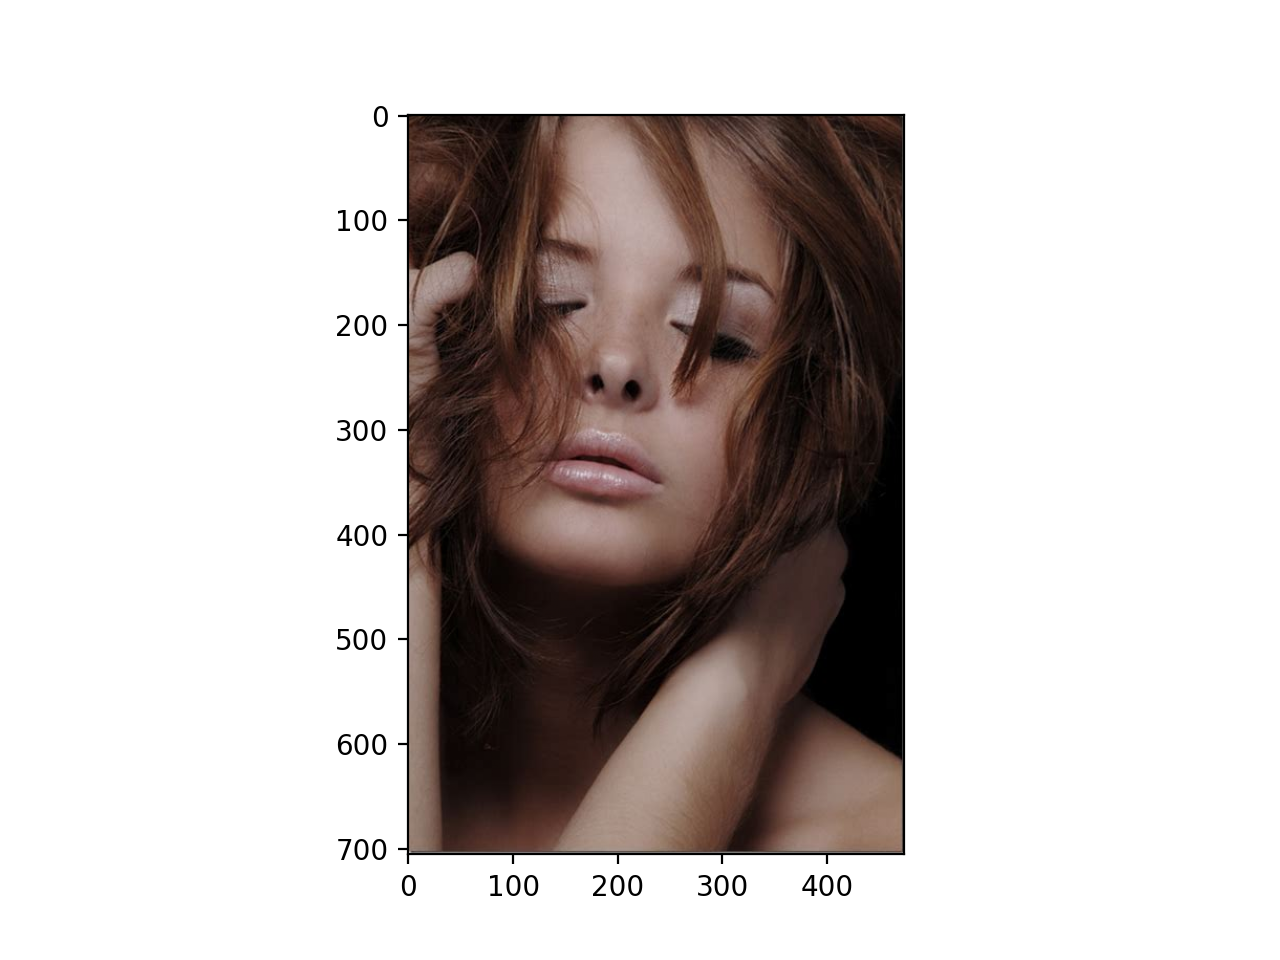

In [6]:
img = skimage.io.imread(fp)

if img.shape[2] == 4:
    img = rgba2rgb(img)
    
if np.max(img) > 1:
    img = img / 255.

hsv_img = rgb2hsv(img)
gray_img = rgb2gray(img)
plt.imshow(img)
plt.show()

In [7]:
# the face/head
if name == 'faces':
    anat_ref_fp = '~/Downloads/IMG_0581.png'
    additional_fps = [
        '~/Downloads/IMG_0582.png',
        '~/Downloads/IMG_0583.png',
        '~/Downloads/IMG_0584.png',
    ]
    
# the spine
elif name == 'spines':
    anat_ref_fp = '../data/anatomy_ref/spine/simplified_torso_angles.png'
    additional_fps = [
        '../data/anatomy_ref/spine/simpliefied_torso_angles_2.png',
        '../data/anatomy_ref/spine/spine.png'
    ]



In [8]:
def get_segmented(img, thresholds):
    new = np.zeros((img.shape[0], img.shape[1], 3))
    new[img <= thresholds[0]] = (0., 0., 0.)
    for i, v1 in enumerate(thresholds):
        if i < len(thresholds) - 1:
            v2 = thresholds[i+1]
            mask = (img >= v1) & (img <= v2)
            new[mask] = COLORS[i]
        else:
            mask = img >= v1
            new[mask] = (1.,1.,1.)
            
    return new

In [9]:
THRESHOLDS = None
def on_range_slider_change(event):
    global THRESHOLDS
    if event['name'] == 'value':
        mapping = interp1d([0, 1], event['new'])
        THRESHOLDS = [mapping(val) for val in defaults]
        x = get_segmented(gray_img, THRESHOLDS)
        axs[0].imshow(x)
        axs[0].axis('off')
        plt.axis('off')

<IPython.core.display.Javascript object>


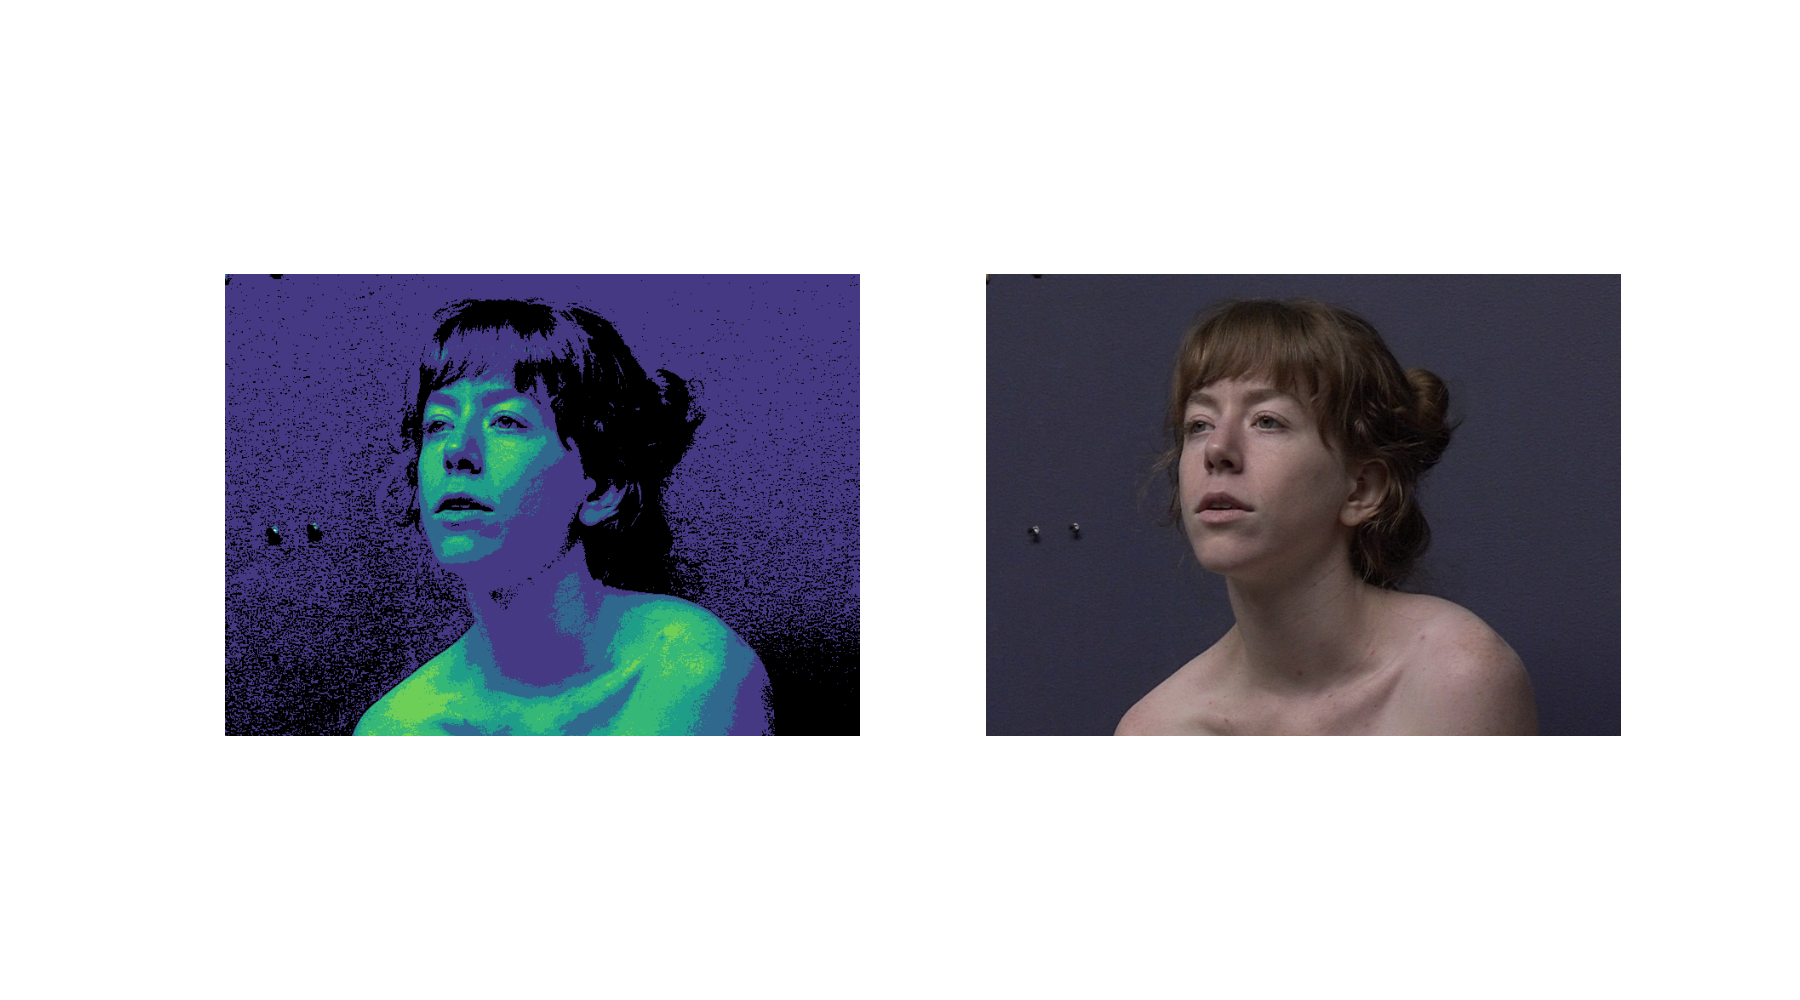

FloatRangeSlider(value=(0.0, 1.0), max=1.1, min=-0.1, step=0.01)

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(9, 5))
axs[1].imshow(img)
defaults = [.1, .3, .5, .6, .7, .8, .90]
COLORS = sns.color_palette('viridis', n_colors=5)[:2] + sns.color_palette('viridis', n_colors=8)[-4:]
slider = widgets.FloatRangeSlider(value=[0, 1], min=-defaults[0], max=1 + 1-defaults[-1], step=.01, readout_format='.2f')
slider.observe(on_range_slider_change)
slider

In [11]:
segmented_img = get_segmented(gray_img, THRESHOLDS)
segmented_img.shape

(543, 746, 3)

<IPython.core.display.Javascript object>


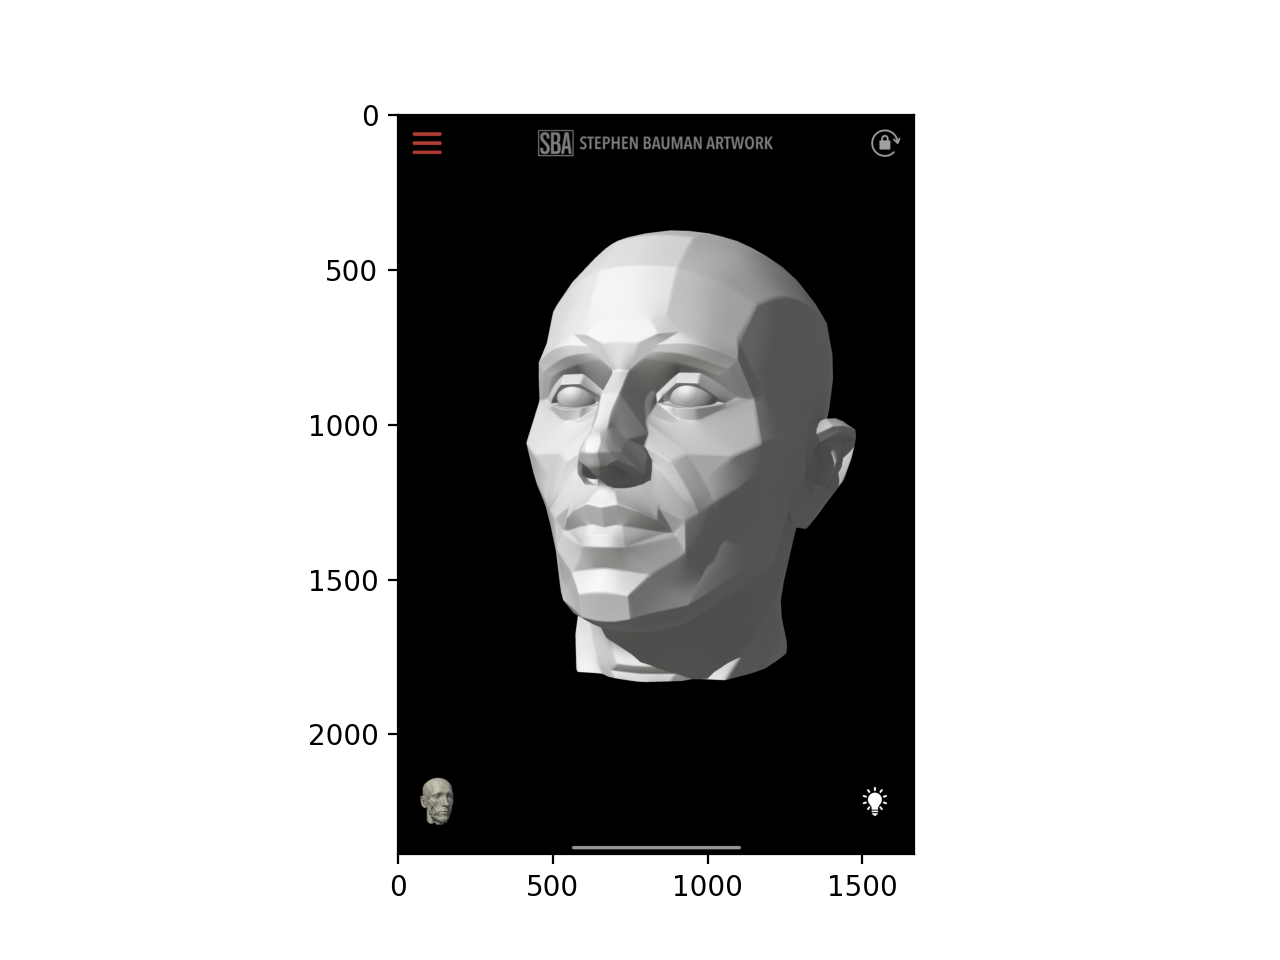

In [12]:
anat_ref_img = skimage.io.imread(anat_ref_fp)
fig, axs = plt.subplots()
plt.imshow(anat_ref_img)

<IPython.core.display.Javascript object>


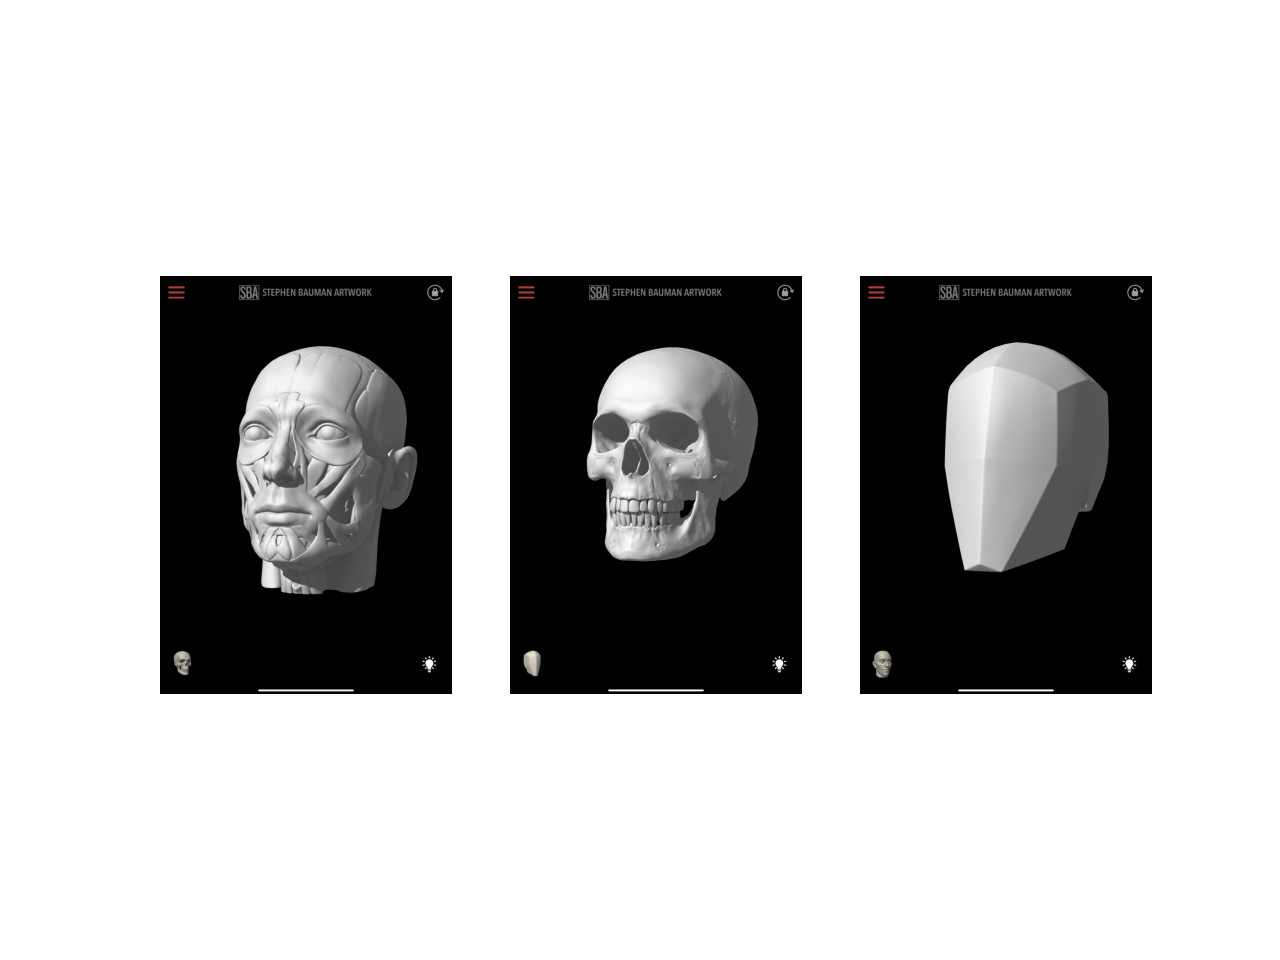

In [14]:
extras = [skimage.io.imread(fp) for fp in additional_fps]
fig, axs = plt.subplots(ncols=len(extras))
for x, ax in zip(extras, axs):
    ax.imshow(x)
    ax.axis('off')

<IPython.core.display.Javascript object>


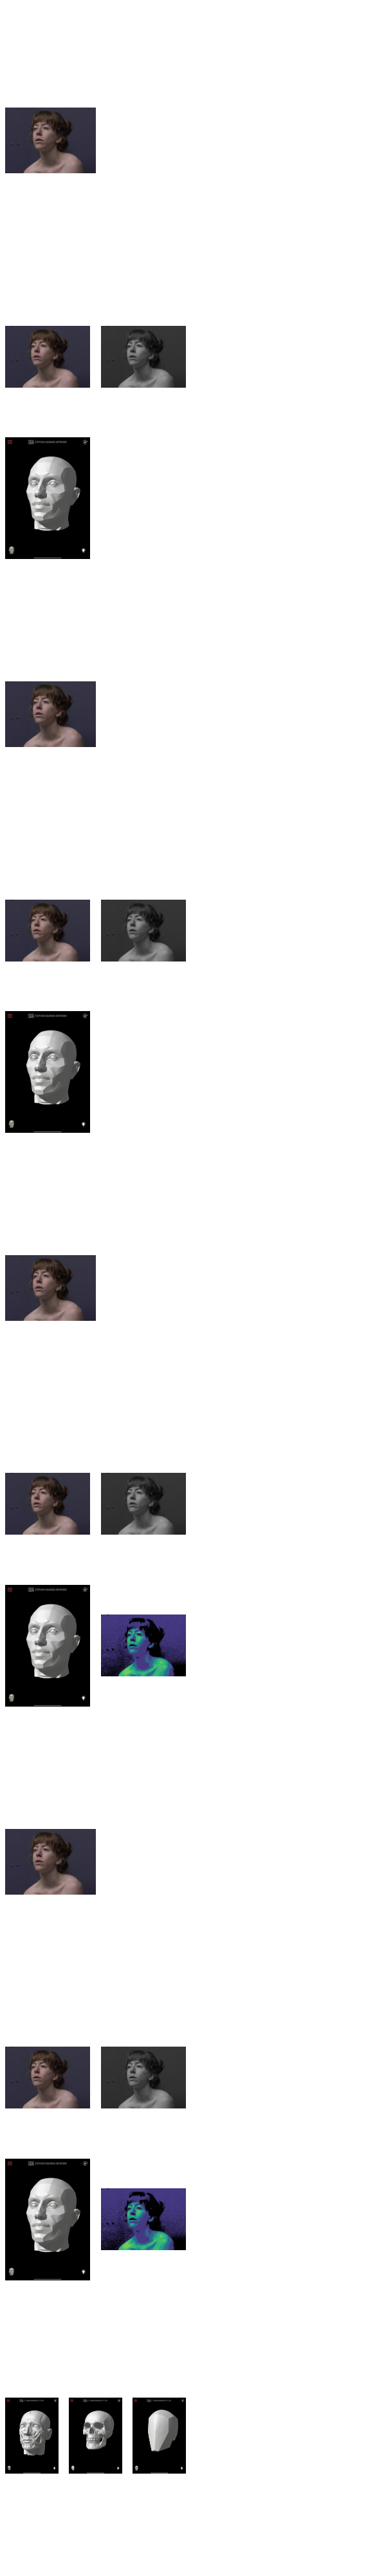

In [15]:
# make reference

img_mapping = {
    'A': img,
    'B': gray_img,
    'C': segmented_img,
    'D': anat_ref_img,
}

for i, extra_img in enumerate(extras):
    img_mapping[str(i)] = extra_img

layouts = [
# anat/plane tracing
'''
AA..
AA..
''',
# redo tracing
'''
AABB
AABB
DD..
DD..
''',
# anat/plane from scratch
'''
AA..
AA..
''',
# redo anat/plane from scratch
'''
AABB
AABB
DD..
DD..
''',
# block in tracing
'''
AA..
AA..
''',
# redo block in tracing
'''
AABB
AABB
DDCC
DDCC
''',
# block in from scratch -> quick finish
'''
AA..
AA..
''',
# evaluate
'''
AABB
AABB
DDCC
DDCC
''',
# extras
''.join([str(i) for i in range(len(extras))])
]

fig = plt.figure(layout="constrained", figsize=(3, 20))
sections = fig.subfigures(nrows=len(layouts), ncols=2)
for section, layout in zip(sections[:, 0], layouts):
    axd = section.subplot_mosaic(layout)
    for k, ax in axd.items():
        if k != '.':
            im = img_mapping[k]
            if len(im.shape) == 2:
                im = gray2rgb(im)
            ax.imshow(im)
        ax.axis('off')
plt.savefig(output_fp, dpi=1200)